In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5) #input num:2 for x,t
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
#optimizer = torch.optim.LBFGS(net.parameters())


In [6]:
def f(x,t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t - 0.01*u_xx-2*u*(1-u)
    #pde = u_x - 2*u_t - u #Exact solution's error(should be 0)
    return pde


In [7]:
x_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_bc = np.zeros((500,1))
u_bc = 0.5*(np.sin(np.pi*x_bc))**2

x2_bc = np.zeros((500,1))
t2_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
u2_bc = np.zeros((500,1))

x3_bc = np.ones((500,1))
t3_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
u3_bc = np.zeros((500,1))
#u_bc = 6*np.exp(-3*x_bc) #BC when t=0


In [8]:
iterations = 20000
previous_validation_loss = 99999999.0
loss_count=[]
for epoch in range(iterations):
    optimizer.zero_grad()

    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc, pt_t_bc)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)

    pt_x2_bc = Variable(torch.from_numpy(x2_bc).float(), requires_grad=False).to(device)
    pt_t2_bc = Variable(torch.from_numpy(t2_bc).float(), requires_grad=False).to(device)
    pt_u2_bc = Variable(torch.from_numpy(u2_bc).float(), requires_grad=False).to(device)

    net_bc_out2 = net(pt_x2_bc, pt_t2_bc)
    mse_u2 = mse_cost_function(net_bc_out2, pt_u2_bc)

    pt_x3_bc = Variable(torch.from_numpy(x3_bc).float(), requires_grad=False).to(device)
    pt_t3_bc = Variable(torch.from_numpy(t3_bc).float(), requires_grad=False).to(device)
    pt_u3_bc = Variable(torch.from_numpy(u3_bc).float(), requires_grad=False).to(device)

    net_bc_out3 = net(pt_x3_bc, pt_t3_bc)
    mse_u3 = mse_cost_function(net_bc_out3, pt_u3_bc)

    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) #Fixed range
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) #Fixed range
    all_zeros = np.zeros((500,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_x_collocation, pt_t_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    loss = mse_u + mse_u2 + mse_u3 + mse_f

    loss.backward()


    optimizer.step()

    with torch.autograd.no_grad():
        loss_count.append(loss.item())
        if epoch % 1000 == 0:
    	    print(epoch,"Traning Loss:",loss.item())


0 Traning Loss: 1.6046255826950073
1000 Traning Loss: 0.08433225750923157
2000 Traning Loss: 0.0841502696275711
3000 Traning Loss: 0.08230999857187271
4000 Traning Loss: 0.08104681968688965
5000 Traning Loss: 0.07732880860567093
6000 Traning Loss: 0.06896057724952698
7000 Traning Loss: 0.004640097729861736
8000 Traning Loss: 0.0027078804560005665
9000 Traning Loss: 0.0021762039978057146
10000 Traning Loss: 0.0019620265811681747
11000 Traning Loss: 0.0019975542090833187
12000 Traning Loss: 0.001767513109371066
13000 Traning Loss: 0.001711570774205029
14000 Traning Loss: 0.0014452573377639055
15000 Traning Loss: 0.00044781650649383664
16000 Traning Loss: 0.0002787550911307335
17000 Traning Loss: 0.0002312447759322822
18000 Traning Loss: 0.00018394632206764072
19000 Traning Loss: 0.00013876304728910327


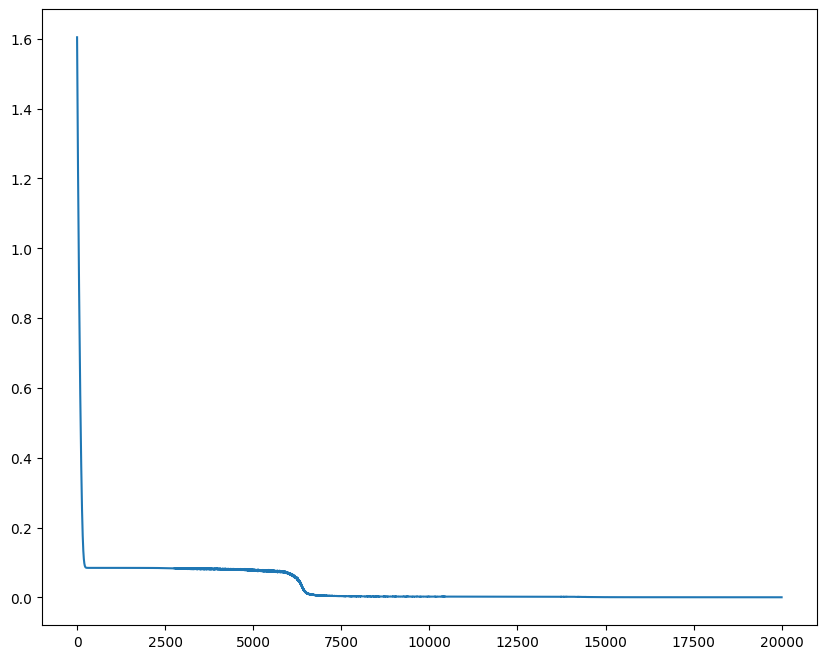

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(loss_count)
plt.show()

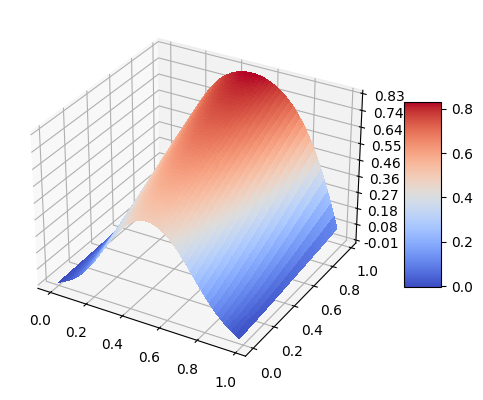

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create a 3D axes

x=np.arange(0,1,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[-1.0473251e-02 -4.1809678e-04  1.0530859e-02  2.2771984e-02
  3.6707491e-02  5.2726120e-02  7.1170062e-02  9.2286289e-02
  1.1616850e-01  1.4270681e-01  1.7156613e-01  2.0221248e-01
  2.3397848e-01  2.6614931e-01  2.9803163e-01  3.2899368e-01
  3.5847434e-01  3.8598105e-01  4.1108152e-01  4.3340251e-01
  4.5263085e-01  4.6851552e-01  4.8086908e-01  4.8956457e-01
  4.9453047e-01  4.9574444e-01  4.9322683e-01  4.8703602e-01
  4.7726673e-01  4.6405107e-01  4.4756144e-01  4.2801601e-01
  4.0568331e-01  3.8088697e-01  3.5400751e-01  3.2548156e-01
  2.9579946e-01  2.6549816e-01  2.3514670e-01  2.0532292e-01
  1.7657676e-01  1.4938432e-01  1.2410283e-01  1.0094300e-01
  7.9965442e-02  6.1098069e-02  4.4168442e-02  2.8938770e-02
  1.5135974e-02  2.4764240e-03]


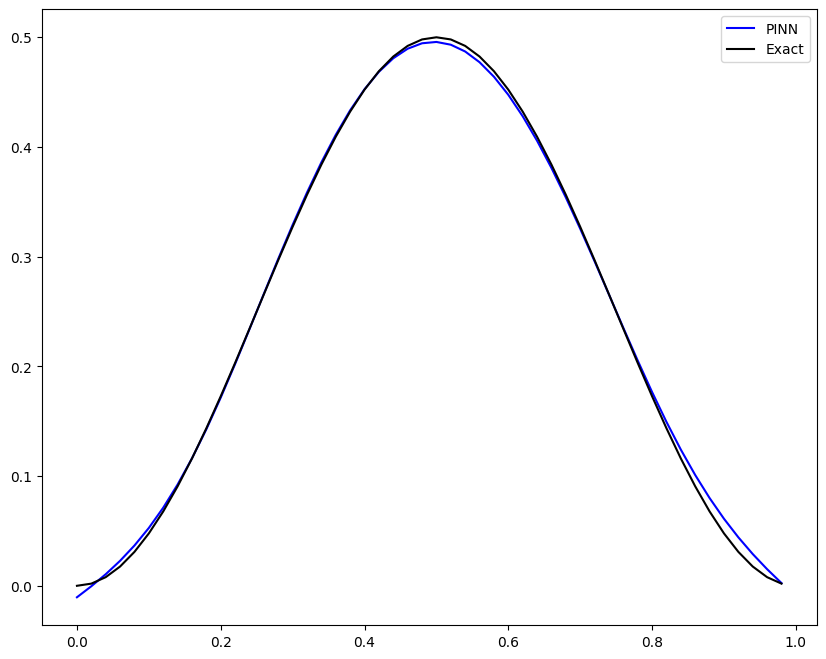

In [11]:
print(ms_t[0])
print(ms_u[0])

ms_u_x25 = [ms_u[i][25] for i in range(len(ms_u))]
y1=0.5*(np.sin(np.pi*ms_x[0]))**2

plt.figure(figsize=(10,8))
plt.plot(ms_x[0],ms_u[0],'b',label='PINN')
plt.plot(ms_x[0],y1,'k',label='Exact')
plt.legend(loc='best')
plt.show()
